In [1]:
import sys
import re
import numpy as np
from operator import add

from pyspark.sql.types import StructType
from pyspark.sql.types import StructField
from pyspark.sql.types import DoubleType
from pyspark.sql.types import IntegerType
from pyspark.sql.types import ArrayType

from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf


In [2]:
## Dataset availible at
## https://www.kaggle.com/uciml/biomechanical-features-of-orthopedic-patients#column_3C_weka.csv ##

filepath = 'data/biomechanical-features-of-orthopedic-patients.csv'
df = spark.read.load(filepath, inferSchema='true', header='true', format='csv')
df.show()

+----------------+-----------+---------------------+------------+-------------+------------------------+------+
|pelvic_incidence|pelvic_tilt|lumbar_lordosis_angle|sacral_slope|pelvic_radius|degree_spondylolisthesis| class|
+----------------+-----------+---------------------+------------+-------------+------------------------+------+
|      63.0278175|22.55258597|          39.60911701| 40.47523153|  98.67291675|            -0.254399986|Hernia|
|     39.05695098|10.06099147|          25.01537822| 28.99595951|  114.4054254|             4.564258645|Hernia|
|     68.83202098|22.21848205|          50.09219357| 46.61353893|  105.9851355|            -3.530317314|Hernia|
|     69.29700807|24.65287791|          44.31123813| 44.64413017|  101.8684951|             11.21152344|Hernia|
|     49.71285934|9.652074879|            28.317406| 40.06078446|  108.1687249|             7.918500615|Hernia|
|     40.25019968|13.92190658|           25.1249496| 26.32829311|  130.3278713|             2.230651729|

In [3]:
#class distribution from dataset
df.groupBy('class').count().show()

+-----------------+-----+
|            class|count|
+-----------------+-----+
|           Hernia|   60|
|Spondylolisthesis|  150|
|           Normal|  100|
+-----------------+-----+



In [4]:
# statistical information on features from dataset
# df.describe().show()

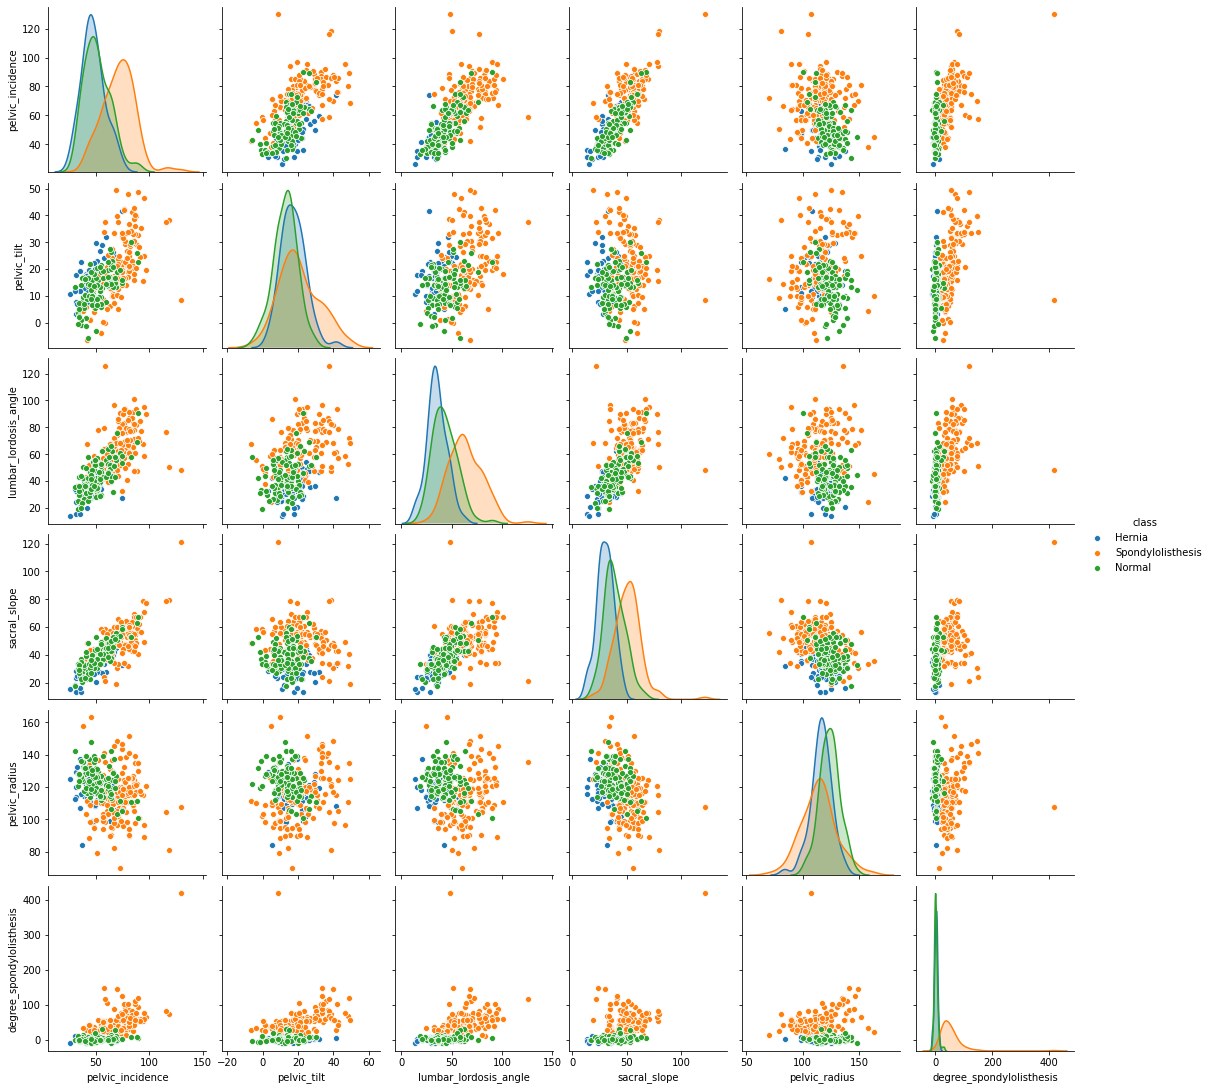

In [19]:
import seaborn as sns
sns.pairplot(data=df.toPandas(), hue='class')

In [6]:
def decretizeClass(className, onlyAbnormal=False, binClasses=False):
    if onlyAbnormal:
        if (className == 'Hernia'): return 0
        elif (className == 'Spondylolisthesis'): return 1
        else: raise ValueError('Normal class present in dataset but specified onlyAbnormal')
    ##else
    if binClasses:
        return 0 if (className == 'Normal') else 1
    else:
        if (className == 'Normal'): return 0
        return 1 if (className == 'Hernia') else 2
    

In [7]:
def createDFforML(filepath, onlyAbnormal=False, binClasses=False):
    sqlContext = SQLContext(sc)
    list_to_vector_udf = udf(lambda l: Vectors.dense(l), VectorUDT())
    schema = StructType([
        StructField('features', ArrayType(DoubleType(), False), False),
        StructField('label', IntegerType(), False)
    ])
    
    rdd = spark.read.load(filepath, inferSchema='true', header='true', format='csv').rdd

    if onlyAbnormal:
        rdd = rdd.filter(lambda x: x[-1] != 'Normal')
    
    #prepare for vector transformation
    rdd = rdd.map(lambda x: (x[:-1], decretizeClass(x[-1], onlyAbnormal=onlyAbnormal, binClasses=binClasses)))
    df = sqlContext.createDataFrame(rdd,schema)
    df_with_vectors = df.select(
        list_to_vector_udf(df['features']).alias('features'),
        df['label']
    )
    return df_with_vectors

# df = createDFforML(filepath, onlyAbnormal=False, binClasses=False)
# df.show()


In [8]:
#The datasets as specified in the accompanying paper
DATASET_ONE = createDFforML(filepath, binClasses=True)
DATASET_TWO = createDFforML(filepath, onlyAbnormal=True)
DATASET_THREE = createDFforML(filepath)


In [9]:
from pyspark.ml.classification import LogisticRegression


##### ON the parameters for the function below:

the Dataset name and BIN allow the function to print the appropriate information for the dataset

changing infoByClass to True will print out additional information from the model

changing the model parameters will alter the results of the model

In [10]:
def runLogRegression(dataset, BIN, infoByClass=False, maxIter=100, regParam=0.03, elasticNetParam=0.8):
    lr = LogisticRegression(maxIter=maxIter, regParam=regParam, elasticNetParam=elasticNetParam)
    lrModel = lr.fit(dataset)
    trainingSummary = lrModel.summary
    
    print('Run for %i iterations with\n\tregParam: %.2f\n\telasticNetParam: %.1f\n' % (maxIter, regParam, elasticNetParam))
    
    # Print the coefficients and intercepts for logistic regression with binomial family (DATASET_ONE or DATASET_TWO)
    if BIN:
        print('Coefficients: [' + ','.join('{:.4f}'.format(k) for k in (lrModel.coefficients).tolist()) + ']')
        print("Intercept: " + str(lrModel.intercept))

    # Print the coefficients and intercepts for logistic regression with multinomial family (DATASET_THREE)
    if not BIN:
        print("Multinomial coefficients:\n" + str(lrModel.coefficientMatrix))
        print("Multinomial intercepts:\n" + str(lrModel.interceptVector))
    
    if infoByClass:
        print()
        # for multiclass, we can inspect metrics on a per-label basis
        print("False positive rate by label:")
        for i, rate in enumerate(trainingSummary.falsePositiveRateByLabel):
            print("label %d: %s" % (i, rate))

        print("True positive rate by label:")
        for i, rate in enumerate(trainingSummary.truePositiveRateByLabel):
            print("label %d: %s" % (i, rate))

        print("Precision by label:")
        for i, prec in enumerate(trainingSummary.precisionByLabel):
            print("label %d: %s" % (i, prec))

        print("Recall by label:")
        for i, rec in enumerate(trainingSummary.recallByLabel):
            print("label %d: %s" % (i, rec))

        print("F-measure by label:")
        for i, f in enumerate(trainingSummary.fMeasureByLabel()):
            print("label %d: %s" % (i, f))
        print()
    
    accuracy = trainingSummary.accuracy
    falsePositiveRate = trainingSummary.weightedFalsePositiveRate
    truePositiveRate = trainingSummary.weightedTruePositiveRate
    fMeasure = trainingSummary.weightedFMeasure()
    precision = trainingSummary.weightedPrecision
    recall = trainingSummary.weightedRecall
    print("Accuracy: %s\nFPR: %s\nTPR: %s\nF-measure: %s\nPrecision: %s\nRecall: %s"
          % (accuracy, falsePositiveRate, truePositiveRate, fMeasure, precision, recall))
    

In [11]:
print('RUNNING LOGISTIC REGRESSION ON DATASET ONE')
runLogRegression(DATASET_ONE, BIN=True, infoByClass=False, maxIter=100, regParam=0.03, elasticNetParam=0.8)


RUNNING LOGISTIC REGRESSION ON DATASET ONE
Run for 100 iterations with
	regParam: 0.03
	elasticNetParam: 0.8

Coefficients: [0.0000,0.0293,0.0000,-0.0112,-0.0458,0.0518]
Intercept: 5.308023899958285
Accuracy: 0.8419354838709677
FPR: 0.22193548387096776
TPR: 0.8419354838709677
F-measure: 0.8403646397032029
Precision: 0.8397502601456817
Recall: 0.8419354838709677


In [12]:
print('RUNNING LOGISTIC REGRESSION ON DATASET TWO')
runLogRegression(DATASET_TWO, BIN=True, infoByClass=False, maxIter=100, regParam=0.03, elasticNetParam=0.8)

RUNNING LOGISTIC REGRESSION ON DATASET TWO
Run for 100 iterations with
	regParam: 0.03
	elasticNetParam: 0.8

Coefficients: [0.0000,0.0000,0.0232,0.0952,0.0000,0.0534]
Intercept: -5.3592795205117945
Accuracy: 0.9761904761904762
FPR: 0.04952380952380952
TPR: 0.9761904761904763
F-measure: 0.976003094814976
Precision: 0.976313332350484
Recall: 0.9761904761904763


In [13]:
print('RUNNING LOGISTIC REGRESSION ON DATASET THREE')
runLogRegression(DATASET_THREE, BIN=False, infoByClass=False, maxIter=100, regParam=0.03, elasticNetParam=0.8)


RUNNING LOGISTIC REGRESSION ON DATASET THREE
Run for 100 iterations with
	regParam: 0.03
	elasticNetParam: 0.8

Multinomial coefficients:
DenseMatrix([[ 0.        , -0.01479938,  0.        ,  0.        ,  0.00872486,
              -0.01216926],
             [ 0.        ,  0.03117762, -0.01916354, -0.07185592, -0.0051642 ,
               0.        ],
             [ 0.        ,  0.        ,  0.0105549 ,  0.0151852 , -0.016803  ,
               0.07844031]])
Multinomial intercepts:
[-1.3017804775063317,2.4961757233715183,-1.1943952458651863]
Accuracy: 0.832258064516129
FPR: 0.07665092165898617
TPR: 0.832258064516129
F-measure: 0.8282646084890125
Precision: 0.8317790336267241
Recall: 0.832258064516129


In [14]:
from pyspark.ml.classification import OneVsRest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [15]:
def runMulticlassEvaluator(dataset, train_split=0.6, test_split=0.4):
    if (1.0 != train_split + test_split):
        raise Exception('Check the train and test split. Not equal to 1.0.')
    
    # generate the train/test split.
    (train, test) = DATASET_THREE.randomSplit([train_split, test_split], 0.64)

    # instantiate the base classifier.
    lr = LogisticRegression(maxIter=100, tol=1E-6, fitIntercept=True)

    # instantiate the One Vs Rest Classifier.
    ovr = OneVsRest(classifier=lr)

    # train the multiclass model.
    ovrModel = ovr.fit(train)

    # score the model on test data.
    predictions = ovrModel.transform(test)

    # obtain evaluator.
    evaluator = MulticlassClassificationEvaluator(metricName="accuracy")

    # compute the classification error on test data.
    accuracy = evaluator.evaluate(predictions)
    print("Test Error = %g" % (1.0 - accuracy))
    

In [16]:
print('Running a multiclass evaluator using the accuracy metric.')
runMulticlassEvaluator(DATASET_ONE)

Running a multiclass evaluator using the accuracy metric.
Test Error = 0.159664


In [17]:
print('Running a multiclass evaluator using the accuracy metric.')
runMulticlassEvaluator(DATASET_TWO)

Running a multiclass evaluator using the accuracy metric.
Test Error = 0.159664


In [18]:
print('Running a multiclass evaluator using the accuracy metric.')
runMulticlassEvaluator(DATASET_THREE)

Running a multiclass evaluator using the accuracy metric.
Test Error = 0.159664


#### I tinkered with regParam values. I'm happy with how they are.
<code> for i in range(1,10):
    i /= 150
    lr = LogisticRegression(maxIter=50, regParam=i, elasticNetParam=0.8)
    lrModel = lr.fit(dfBIN)
    print('fitting for regParam %.3f' % (i))
    print('Coefficients: [' + ','.join('{:.4f}'.format(k) for k in (lrModel.coefficients).tolist()) + ']')
    print("Intercept: " + str(lrModel.intercept))
    trainingSummary = lrModel.summary
    accuracy = trainingSummary.accuracy
    falsePositiveRate = trainingSummary.weightedFalsePositiveRate
    truePositiveRate = trainingSummary.weightedTruePositiveRate
    fMeasure = trainingSummary.weightedFMeasure()
    precision = trainingSummary.weightedPrecision
    recall = trainingSummary.weightedRecall
    print("Accuracy: %s\nFPR: %s\nTPR: %s\nF-measure: %s\nPrecision: %s\nRecall: %s"
          % (accuracy, falsePositiveRate, truePositiveRate, fMeasure, precision, recall))
    print()</code> 